In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import matplotlib
import scanpy as sc

In [2]:
# Settings

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()

sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')
# low dpi (dots per inch) yields small inline figures

results_file = './write/paul15.h5ad'


In [3]:
adata = sc.datasets.paul15()
adata

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

In [4]:
# Simple preprocessing recipe

sc.pp.recipe_zheng17(adata)

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)


In [5]:
# PCA

sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:00)


In [6]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:12)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


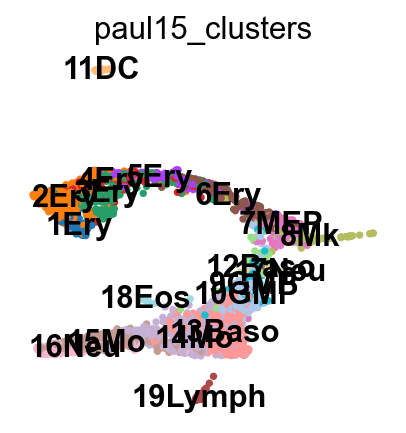

In [7]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

## Optional : Denoising the graph

---

To denoise the graph, we represent it in diffusion map space (and not in PCA space). Computing distances within a few diffusion components amounts to denoising the graph - we just take a few of the first spectral components. It’s very similar to denoising a data matrix using PCA. The approach has been used in a couple of papers, see e.g. Schiebinger et al. (2017) or Tabaka et al. (2018). It’s also related to the principles behind MAGIC Dijk et al. (2018).

---

This is not a necessary step, neither for PAGA, nor clustering, nor pseudotime estimation. You might just as well go ahead with a non-denoised graph. In many situations (also here), this will give you very decent results.

In [8]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.99896455 0.9967852  0.9944013  0.9892853
     0.98826355 0.9871257  0.9838318  0.98297554 0.9789326  0.9768995
     0.97440886 0.9727857  0.9661876 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [9]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:11)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


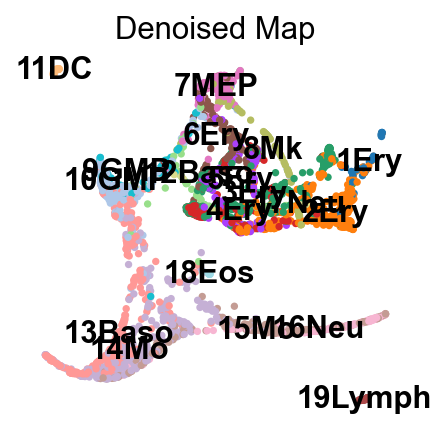

In [10]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data', title="Denoised Map")

# Clustering and PAGA

In [11]:
sc.tl.leiden(adata, resolution=1.0)

running Leiden clustering
    finished: found 33 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [12]:
# For simple, coarse-grained visualization, compute the PAGA graph, a coarse-grained and simplified (abstracted) graph. 
# Non-significant edges in the coarse- grained graph are thresholded away.

sc.tl.paga(adata, groups='leiden')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


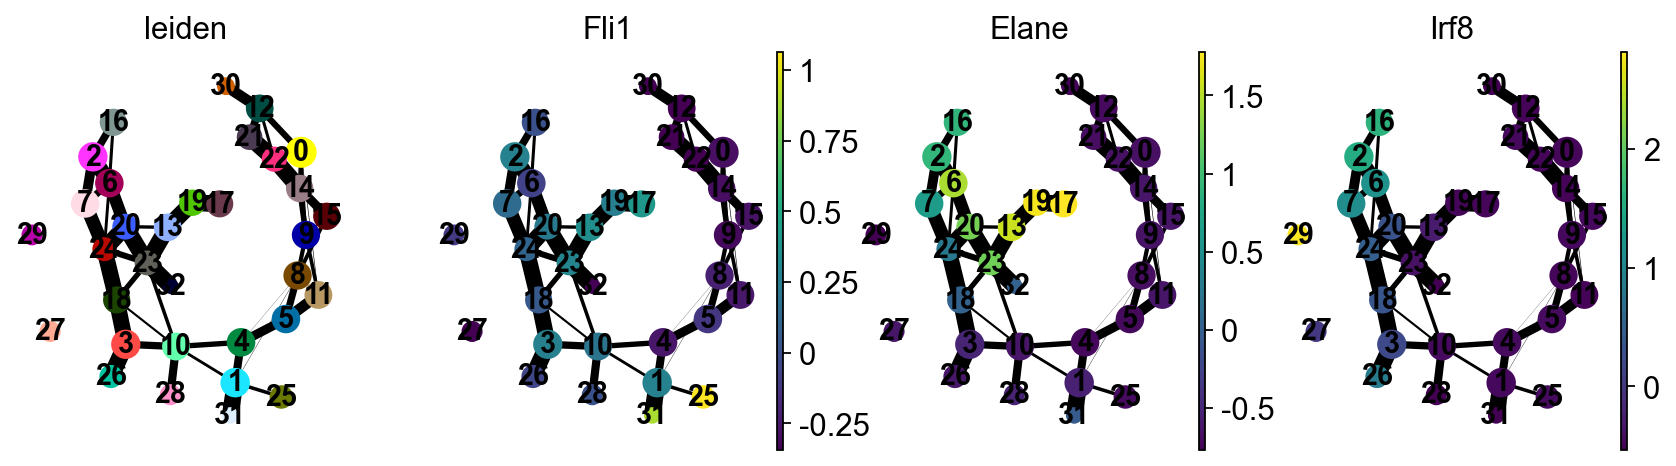

In [13]:
sc.pl.paga(adata, color=['leiden', 'Fli1', 'Elane', 'Irf8'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


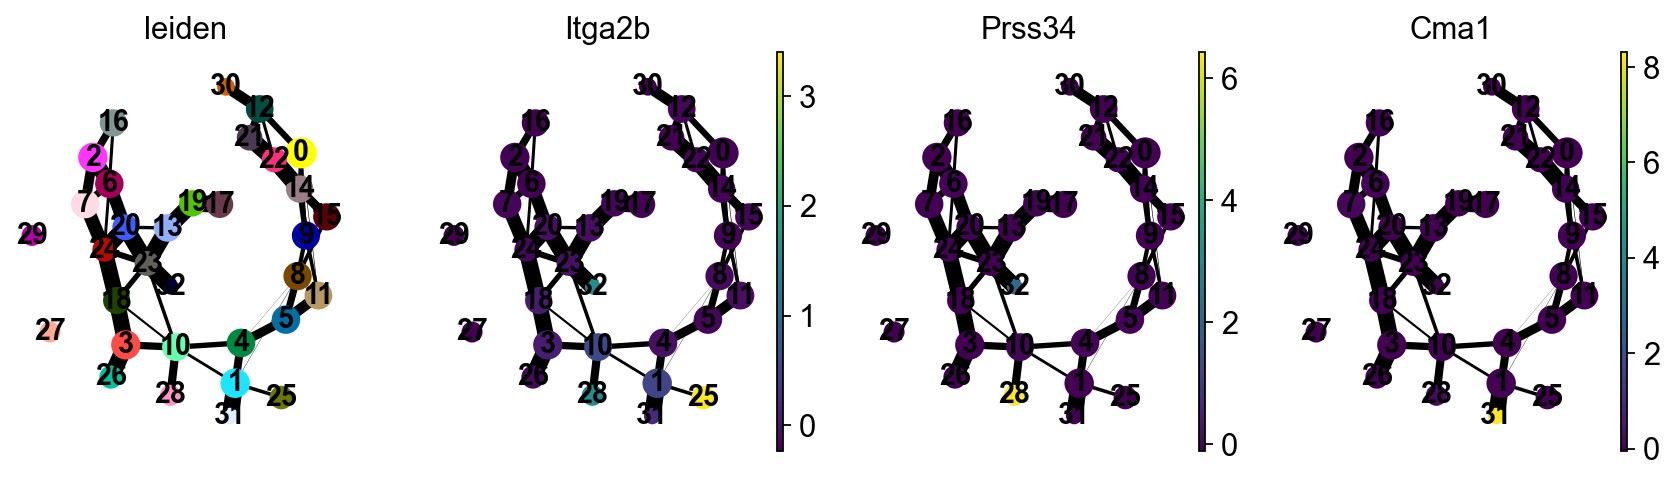

In [14]:
sc.pl.paga(adata, color=['leiden', 'Itga2b', 'Prss34', 'Cma1'])

In [20]:
# Actually annotate the clusters — note that Cma1 is a Mast cell marker and only appears in a small fraction of the
# cells in the progenitor/stem cell cluster 8, see the single-cell resolved plot below.

adata.obs['leiden'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32'],
      dtype='object')

In [22]:
# Not real clusters, just examples to understand how to use the functions

adata.obs['leiden_anno'] = adata.obs['leiden']

adata.obs['leiden_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10/Ery', '11', '12',
       '13', '14', '15', '16/Stem', '17', '18', '19/Neu', '20/Mk', '21', '22/Baso', '23', '24/Mo', '25', '26', '27',
                                          '28', '29', '30', '31', '32']


/var/folders/0l/5dgm9v295cz3jngvfm2pmflh0000gn/T/ipykernel_1901/2392655047.py:5: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  adata.obs['leiden_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10/Ery', '11', '12',


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


<Axes: >

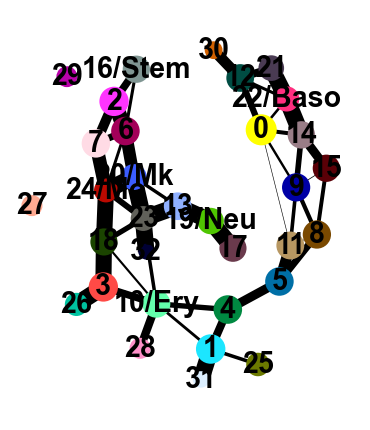

In [24]:
sc.tl.paga(adata, groups='leiden_anno')
sc.pl.paga(adata, threshold=0.03, show=False)

### Recomputing the embedding using PAGA-initialization

---

The following is just as well possible for a UMAP

In [25]:
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:10)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


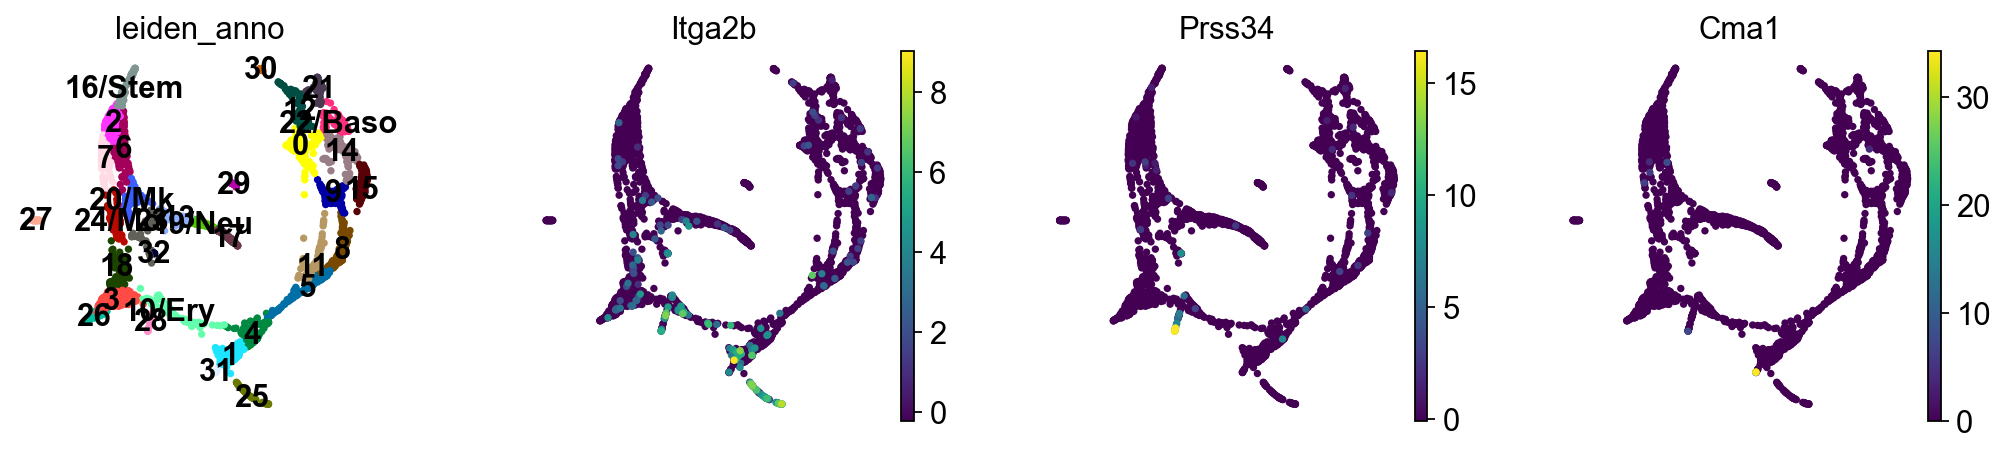

In [27]:
sc.pl.draw_graph(adata, color=['leiden_anno', 'Itga2b', 'Prss34', 'Cma1'], legend_loc='on data')


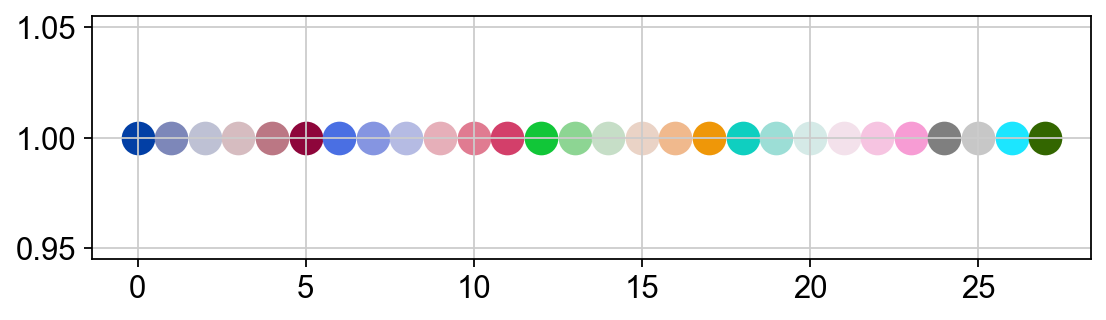

In [28]:
# Choose the colors of the clusters a bit more consistently.

pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200)
pl.show()

In [31]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_28)
new_colors = np.array(adata.uns['leiden_anno_colors'])

OverloadedDict, wrapping:
	OrderedDict([('iroot', 840), ('log1p', {'base': None}), ('pca', {'params': {'zero_center': True, 'use_highly_variable': False}, 'variance': array([69.31142  , 20.954046 , 13.321655 ,  9.685735 ,  8.569481 ,
        7.8076534,  6.4687543,  5.9765286,  4.911763 ,  4.5213237,
        4.1150155,  3.6618793,  3.560782 ,  3.4015698,  3.1836693,
        3.1097136,  2.944109 ,  2.9159026,  2.856262 ,  2.7730622,
        2.7343242,  2.7212574,  2.6749923,  2.6149006,  2.6064773,
        2.5783412,  2.5510383,  2.5317197,  2.5105119,  2.4790301,
        2.4545681,  2.438798 ,  2.4339328,  2.422869 ,  2.4094589,
        2.3706214,  2.364925 ,  2.3390121,  2.3260906,  2.3001995,
        2.2892535,  2.270625 ,  2.25648  ,  2.2513213,  2.2355304,
        2.2288551,  2.2247114,  2.215144 ,  2.2063003,  2.2040102],
      dtype=float32), 'variance_ratio': array([0.06938081  , 0.020975027 , 0.013334993 , 0.009695432 ,
       0.008578061 , 0.007815471 , 0.006475231 , 0.00598251

In [32]:
new_colors[[16]] = zeileis_colors[[12]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[[5, 5, 5, 5, 11, 11, 10, 9, 21, 21]]  # Ery colors / red
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 0]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey

In [33]:
adata.uns['louvain_anno_colors'] = new_colors

And add some white space to some cluster names. The layout shown here differs from the one in the paper, which can be found [here](https://github.com/theislab/paga/blob/f53fcdf4a861b7d3410f8096ffc13a07f1d225c0/blood/paul15/paul15.ipynb). These differences, however, are only cosmetic. We had to change the layout as we moved from a randomized PCA and float32 to float64 precision.

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


--> added 'pos', the PAGA positions (adata.uns['paga'])


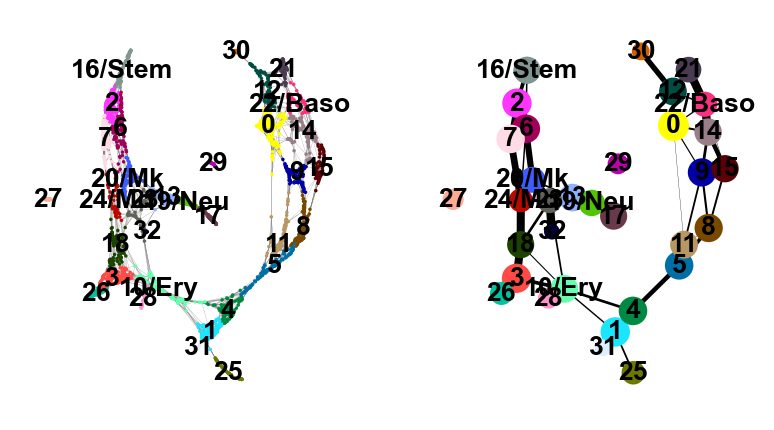

In [34]:
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

# Reconstructing gene changes along PAGA paths for a given set of genes

---

Choose a root cell for diffusion pseudotime.

In [38]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden_anno']  == '4')[0]
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [39]:
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

In [40]:
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


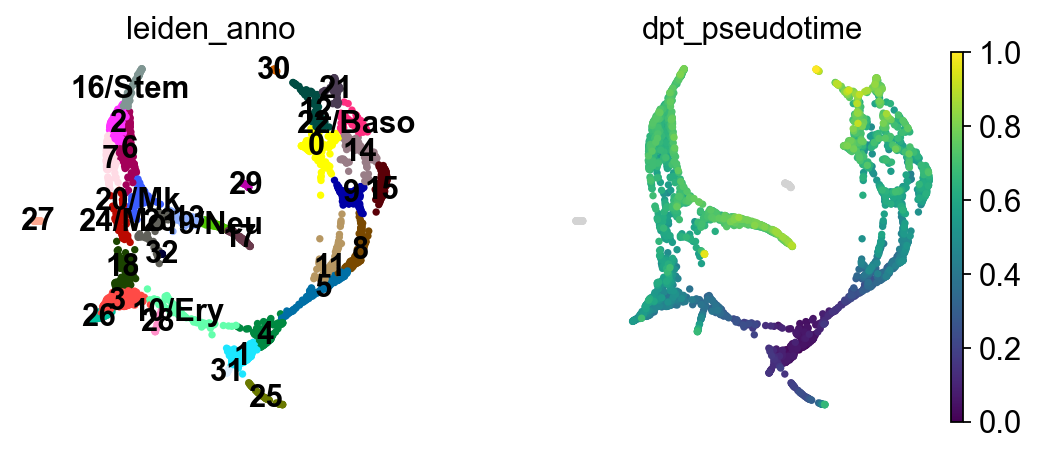

In [42]:
sc.pl.draw_graph(adata, color=['leiden_anno', 'dpt_pseudotime'], legend_loc='on data')

In [45]:
# Probably false because we don't use the same algorithm as in the example

paths = [('erythrocytes', [16, 12, 7, 13, 18, 6, 5, 10]),
         ('neutrophils', [16, 0, 4, 2, 14, 19]),
         ('monocytes', [16, 0, 4, 11, 1, 9, 24])]

In [46]:
adata.obs['distance'] = adata.obs['dpt_pseudotime'] # just a cosmetic change

In [47]:
adata.obs['clusters'] = adata.obs['leiden_anno']  # just a cosmetic change

In [48]:
adata.uns['clusters_colors'] = adata.uns['leiden_anno_colors'] # just a cosmetic change

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/paga.py:1229: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/paga.py:1276: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


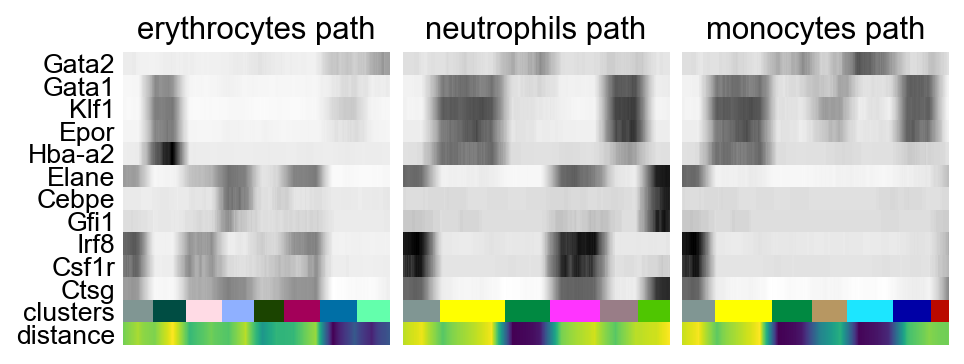

In [53]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_path_paul15.pdf')
pl.show()